# Variational Entropy Search
This notebook has some experiments with variational entropy search method

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

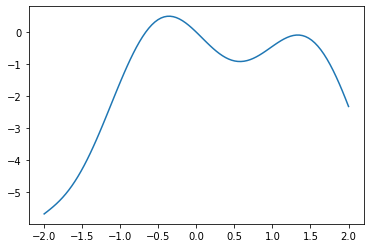

In [34]:
noise = 0.01
# Gaussian process with RBF kernel as surrogate model
rbf = ConstantKernel(5.0) * RBF(1.0)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2)

def f(X, noise=noise):
    return (-np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)).flatten()

X_data = np.array([[-1.8], [0.0],[1.4], [1.8]])
Y_data = f(X_data)
X = np.linspace(-2,2,100)[:,None]
bounds = np.array([[-2.0, 2.0]])

# Gaussian process regression
gpr = gpr.fit(X_data,Y_data)
Y_mu,Y_sigma = gpr.predict(X,return_std=True)
Y = f(X,0)

plt.plot(X,Y)
plt.show()

In [40]:
from rff import rff_posterior
# Conduct RFF 
kernel = 'rbf'
lengthscale = 1.0
coefficient = 5.0
num_functions = 100
num_features = 10

functions = rff_posterior(X_data, Y_data, X, kernel, lengthscale, coefficient, num_functions, num_features, noise)

rff_mu, rff_std = np.mean(functions,axis=0),np.std(functions,axis=0)

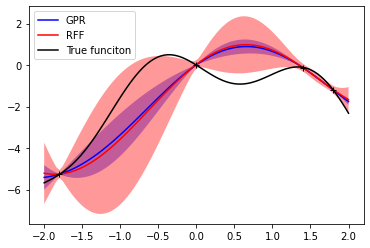

In [41]:
plt.plot(X,Y_mu,c='b',label='GPR')
plt.fill_between(X.flatten(),Y_mu+1.94*Y_sigma,Y_mu-1.94*Y_sigma,facecolor='b',alpha=0.4)
plt.plot(X,rff_mu,c='r',label='RFF')
plt.fill_between(X.flatten(),rff_mu+1.94*rff_std,rff_mu-1.94*rff_std,facecolor='r',alpha=0.4)
plt.plot(X,f(X,0.0),c='k',label='True funciton')
plt.plot(X_data,Y_data,'+k')
plt.legend()
plt.show()

In [37]:
from scipy.stats import norm

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei

from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

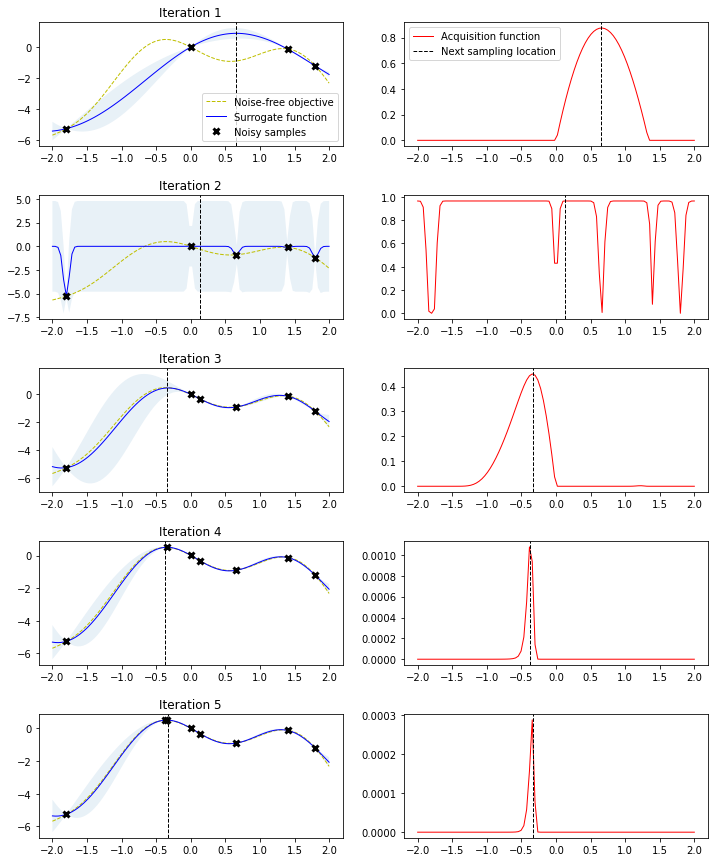

In [38]:
from bayesian_optimization_util import plot_approximation, plot_acquisition, plot_kde

### Expected improvement
# Gaussian process with RBF kernel as surrogate model
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2)

# Initialize samples
X_sample = X_data
Y_sample = Y_data

# Number of iterations
n_iter = 5

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.hstack((Y_sample, Y_next))

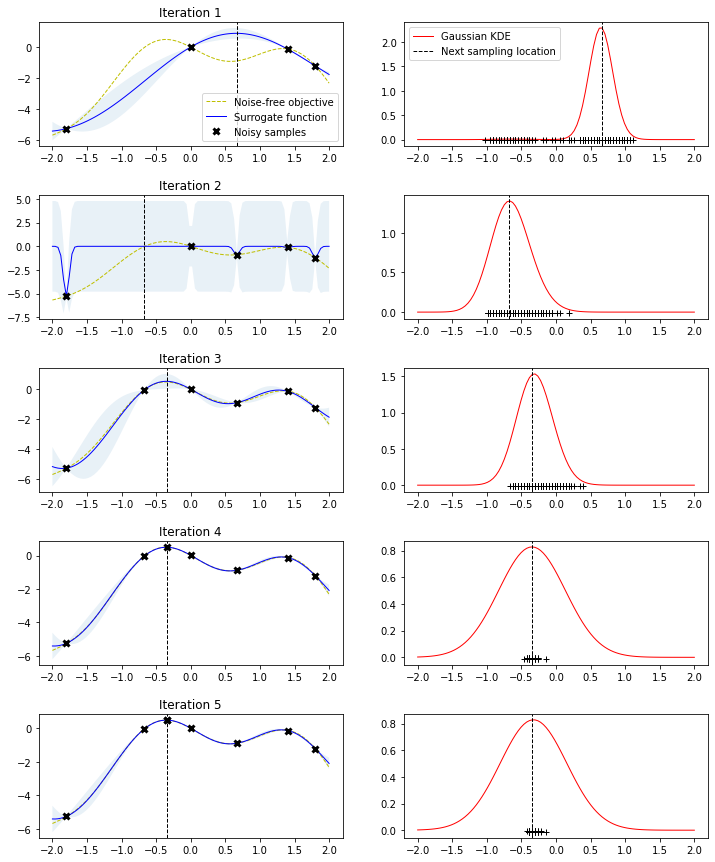

In [39]:
from rff import rff_sgd
### Our proposed method
# Gaussian process with RBF kernel as surrogate model
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2)

# Initialize samples
X_sample = X_data
Y_sample = Y_data

# Number of iterations
n_iter = 5
step_size = 1.0
max_iter = int(1e4)
num_functions = 1000
num_features = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)
    
    X_init = X_sample[np.argmax(Y_sample)]

    X_next,X_lst = rff_sgd(X_sample,Y_sample,X,X_init,max_iter,step_size,
                   kernel,lengthscale,coefficient,num_functions,
                   num_features,noise,return_x=True)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_kde(X_lst,X, X_next, show_legend=i==0,kernel='gaussian')
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.hstack((Y_sample, Y_next))